In [12]:
import sys
sys.path.append("..")
sys.path.append("../src/")

In [13]:
from src.model.model import get_model
from src.data.data import train_val_test_split
from src.model.train import train_model, test_model
from src.config import cfg
from src.visualization.visualize import statistical_plot, plot_sample
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
import seaborn as sns
from os.path import join, exists
from os import makedirs
%matplotlib inline

In [14]:
epochs = cfg.epochs # 500
num_of_tries = cfg.num_of_tries # 10
is_cuda = torch.cuda.is_available()
target = "weight" # weight, height
type = "asia" # female, male, asia, test, west
continue_epochs = 5000
device = torch.device("cuda") if is_cuda else torch.device('cpu')
model_name = "asia"

In [15]:
folder_name = model_name + "_" + target
output_address = join(cfg.output_path, folder_name)
if not exists(output_address):
    makedirs(output_address)

In [16]:
model = get_model(target=target, type=type, is_continue=True)

Loading weight_asia_best_model.pt
Getting model for continue training!


In [17]:
from src.model.loss import MAELoss
test_criterion = MAELoss().to(device)

In [18]:
def get_numpy_images(tensor):
    images = []
    numpy_images = tensor.numpy()
    for index in range(numpy_images.shape[0]):
        image = numpy_images[index, :,:,:].transpose(1,2,0)
        images.append(image)
    return images

def plot_box(losses, target, type, avg_loss, color="coral"):
    t = list(range(1, len(losses)+1))
    df = pd.DataFrame(list(zip(t, losses)), columns=['Sample-th', 'Test loss'])
    print(df['Test loss'].describe())
    plt.figure(figsize=(25,3))
    ax = sns.boxplot(df['Test loss'], color=color);
    fig = ax.get_figure()
    file_name = target + "_" + type + "_" + f'{avg_loss:.4f}' + "_box_plot.png"
    file_address = join(output_address, file_name)
    fig.savefig(file_address)
    return df

def test_data(target="bmi", type="west"):
    test_loss = 0.0
    all_losses = []
    all_images = []
    _, _, test_loader = train_val_test_split(type=type)
    print(f"\tTesting model with target {target}")
    with torch.no_grad():
        model.eval()
        for images, height, weight, bmi in test_loader:
            images, height, weight, bmi = images.to(device), height.to(device), weight.to(device), bmi.to(device)
            predictions = model(images)
            if target == "bmi":
                loss, all_loss  = test_criterion(predictions, bmi)
            elif target == "height":
                loss, all_loss = test_criterion(predictions, height)
            elif target == "weight":
                loss, all_loss = test_criterion(predictions, weight)
            test_loss += loss.item()*images.size(0)
            all_losses +=  all_loss.squeeze().tolist()
            all_images += get_numpy_images(images)

    # average test loss
    test_loss = test_loss/len(test_loader.sampler)
    print(f"Testing loss for {target} with {type} data is: {test_loss:.3f}")
    print(f"Image 0 has error: {all_losses[0]:.3f}")
    print("Image at 0 is:")
    plt.imshow(all_images[0]);
    return all_losses, all_images, test_loss

def get_quantile(losses, df, level='upper'):
    if level == 'upper':
        index_quantile = [i for i in range(len(losses)) if losses[i] >= df['Test loss'].describe()['75%']]
    elif level == 'lower':
        index_quantile = [i for i in range(len(losses)) if losses[i] <= df['Test loss'].describe()['25%']]
    
    value_quantile = [value for value in losses if losses.index(value) in index_quantile]
    zipped_lists = zip(value_quantile, index_quantile)
    sorted_zipped_lists = sorted(zipped_lists)
    # print(sorted_zipped_lists)
    quantile = [element for _, element in sorted_zipped_lists]
    return quantile

def plot_quantile(level, losses, images, df, target='bmi', type='west'):
    quantile = get_quantile(level=level, losses=losses, df=df)
    fig = plt.figure(figsize=(20, len(quantile)))
    for idx, value in enumerate(quantile):
        ax = fig.add_subplot(11, 5, idx+1, xticks=[], yticks=[])
        plt.imshow(images[value])
        ax.set_title(f"Error:{losses[value]:.2f}", color=("red"))
    file_name = target + "_" + type + "_"+ level + "_" + "error_images.png"
    file_address = join(output_address, file_name)
    fig.savefig(file_address)

Running with Asian test data!
	Train size: 0 images
	Validation size: 0 images
	Test size: 208 images
	Testing model with target weight
Testing loss for weight with test data is: 7.206
Image 0 has error: 21.287
Image at 0 is:


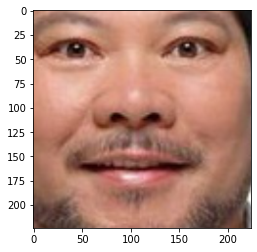

In [19]:
asian_all_losses, asian_all_images, asian_avg_loss = test_data(target=target, type="test")

count    208.000000
mean       7.205800
std        6.457775
min        0.040497
25%        2.868369
50%        5.244310
75%        9.708841
max       38.003124
Name: Test loss, dtype: float64


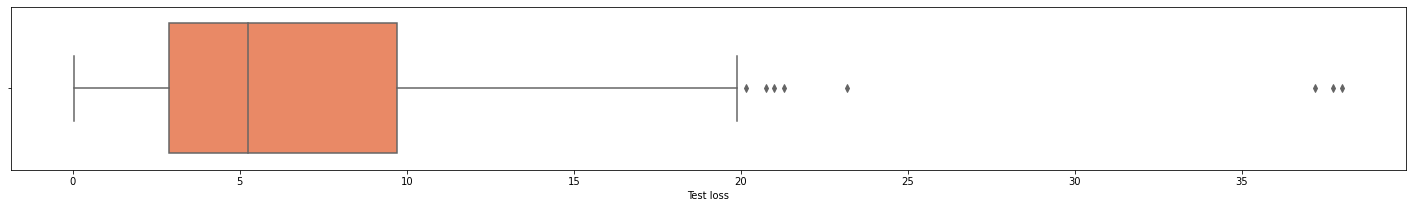

In [20]:
df_asian = plot_box(losses = asian_all_losses, target=target, type="test", avg_loss=asian_avg_loss)

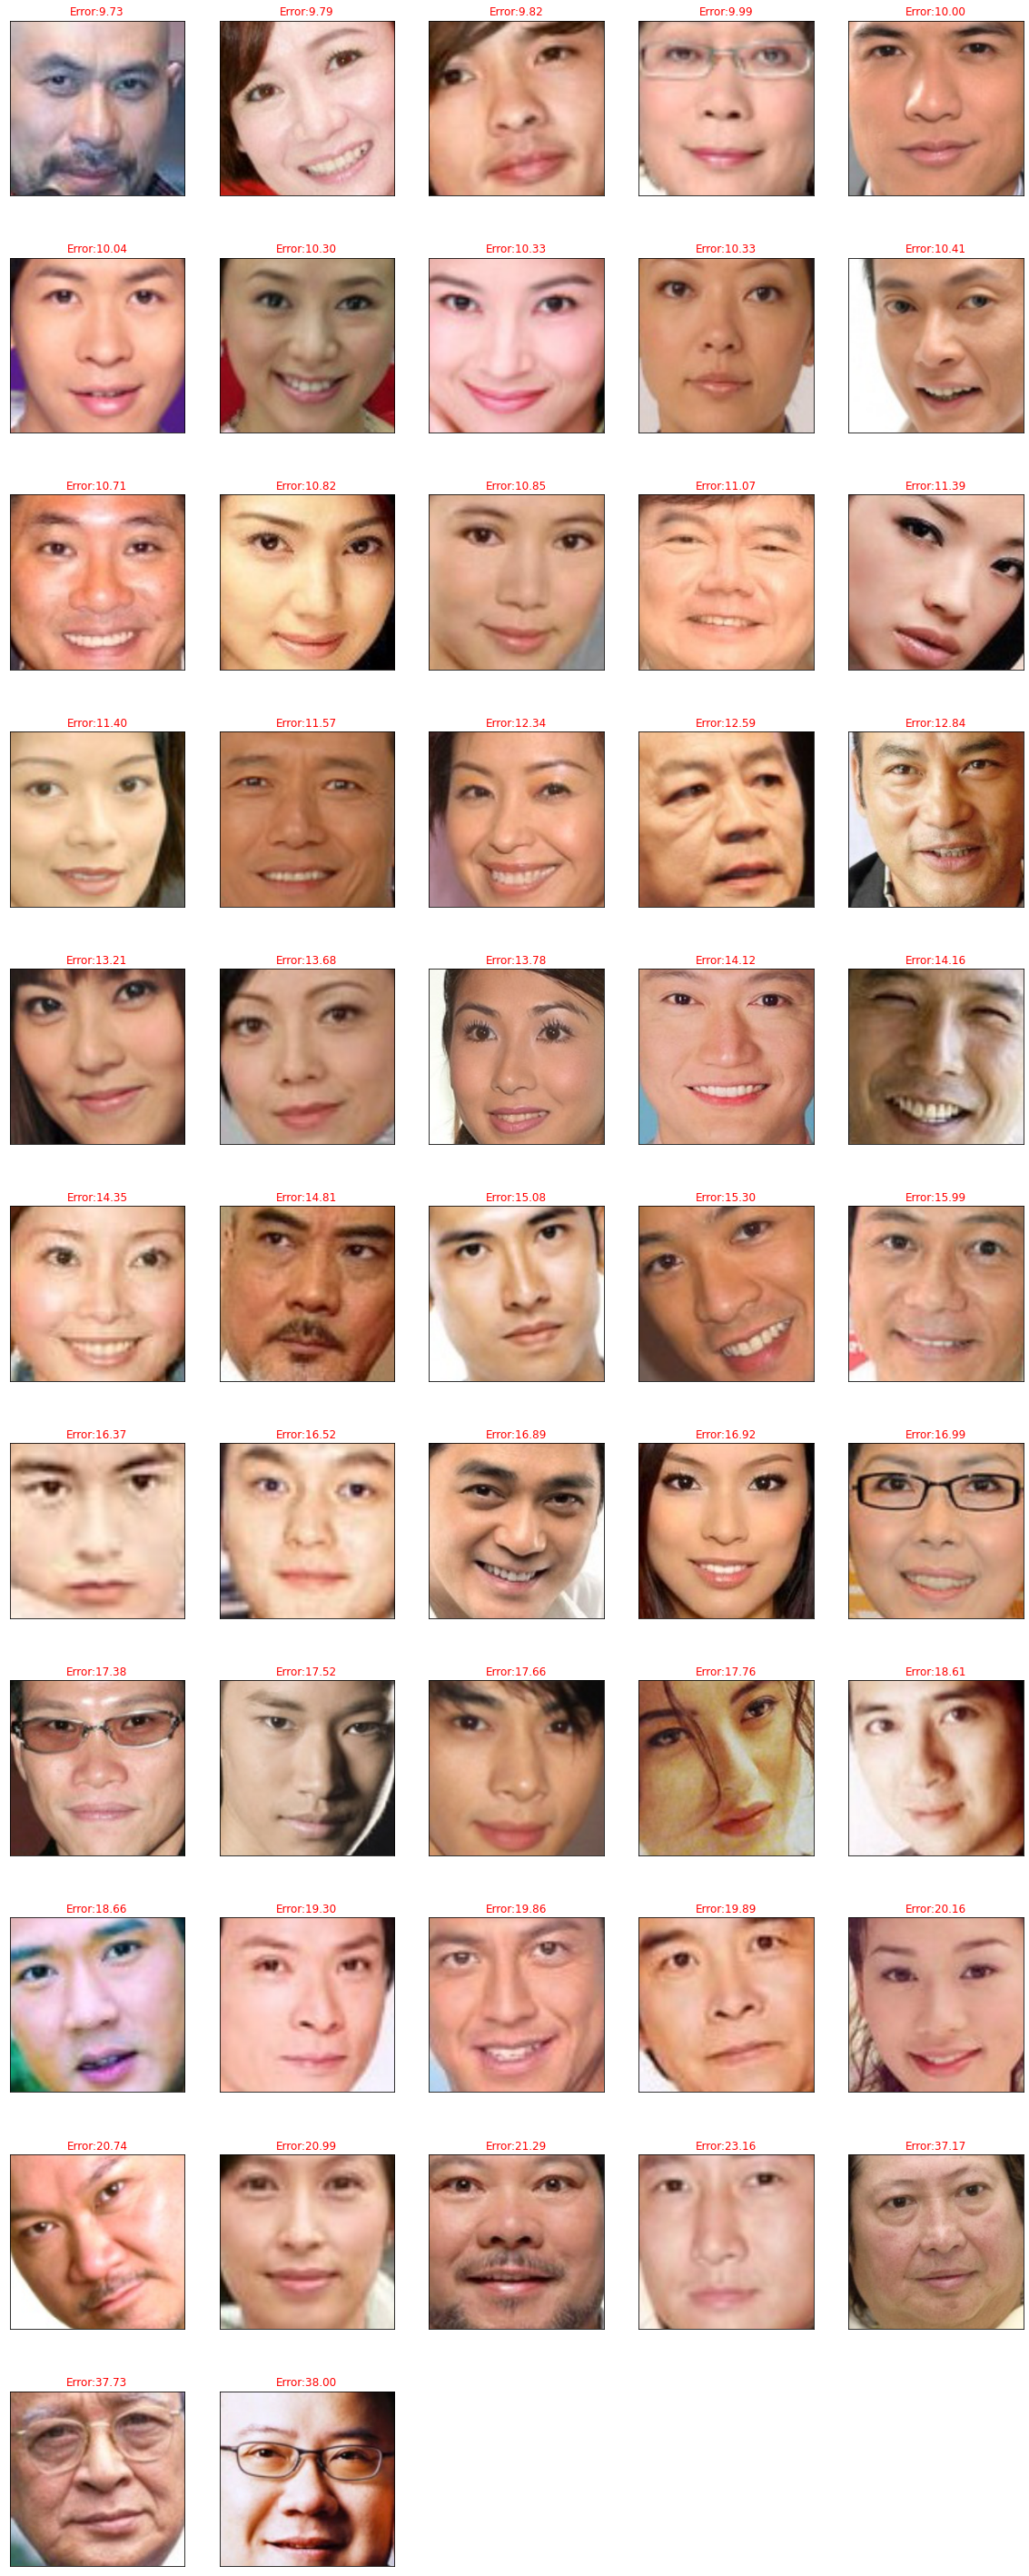

In [21]:
plot_quantile(level = "upper", losses = asian_all_losses, images = asian_all_images, df=df_asian, type='test')